# 2013 Boston Marathon Clusters

In [9]:
# Import modules.
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

# Clustering module imports.
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from itertools import cycle

# Aesthetics.
%matplotlib inline
sns.set_style('darkgrid')

In [10]:
def viewDf(dataframe):
    """Prints general dataframe info."""
    print('General info:')
    print(dataframe.info())
    print('\nNull Counts:\n', dataframe.isnull().sum())
    print('\nStatistics:\n', dataframe.describe())
    print('\nViewing...')
    return dataframe.head()

## EDA

In [11]:
# Load dataset.
raw_data = pd.read_csv('~/src/data/unit4/boston-results-2013.csv')

# Rename to df.
df = raw_data

# Preview dataframe.
viewDf(df)

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB
None

Null Counts:
 25k              0
age              0
name             0
divisi

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


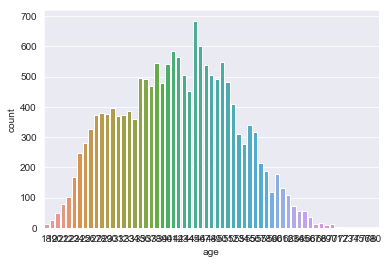

c:\users\mewing_user\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


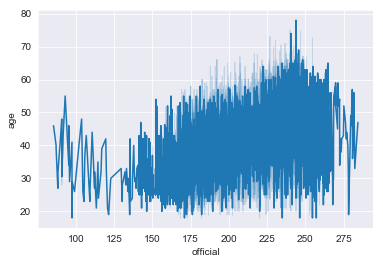

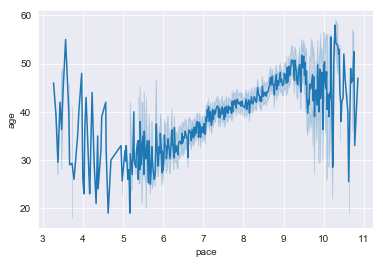

In [12]:
# Age.
g = sns.countplot('age', data=df)
plt.show()

# Age & Official.
g = sns.lineplot(x='official', y='age', data=df)
plt.show()

# Age & Pace.
g = sns.lineplot(x='pace', y='age', data=df)
plt.show()

In [13]:
df.describe()

,age,division,official,overall,pace,genderdiv
count,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000
mean,41.638332,1100.967025,208.159470,8429.373422,7.947398,4351.684732
std,10.351311,942.114816,23.743608,5052.024116,0.905739,2772.398239
min,18.000000,1.000000,85.530000,1.000000,3.270000,1.000000
25%,34.000000,363.000000,191.727500,4061.750000,7.320000,2032.750000
50%,42.000000,842.000000,209.225000,8247.500000,7.980000,4113.500000
75%,49.000000,1560.000000,225.230000,12662.250000,8.600000,6316.000000
max,80.000000,3834.000000,284.230000,17598.000000,10.850000,10648.000000


In [14]:
def processDf(dataframe):
    """Preps the dataframe for analysis per user preferences."""
    # Removes unecessary columns.
    dataframe = dataframe.drop(['name', 'ctz', 'state', 'city', 
    'country', 'bib'], axis = 1)
    # Removes null indexes.
    dataframe = dataframe.dropna(axis = 0)
    for i in ['5k', '10k', '20k', '25k', '30k', '35k', '40k', 
    'half']:
        # Removes runners with '-'. 
        dataframe = dataframe[dataframe[i] != '-']
        # Converts dtype.
        dataframe[i] = dataframe[i].astype('float64')
    # Gender categorical feature, creating dummies.
    gender_dummies = pd.get_dummies(dataframe.gender)
    # Reordering dataframe.
    dataframe_cols = dataframe[['age', 'division', 'genderdiv', 
    'overall', '5k', '10k', '20k', '25k', '30k', '35k', '40k', 
    'pace', 'half', 'official']]
    dataframe = pd.concat([gender_dummies, dataframe_cols], axis = 1)
    return dataframe

In [15]:
# Process the dataframe.
df = processDf(df)

# Dropping the first 2 indexes to allow length of values to match length of index.
df = df.iloc[2:]
df = df.reset_index(drop=True)

# Float64 change dtype.
df.F = df.F.astype('float64')
df.M = df.M.astype('float64')
df.age = df.age.astype('float64')
df.division = df.division.astype('float64')
df.genderdiv = df.genderdiv.astype('float64')
df.overall = df.overall.astype('float64')

# View altered dataframe.
viewDf(df)

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16052 entries, 0 to 16051
Data columns (total 16 columns):
F            16052 non-null float64
M            16052 non-null float64
age          16052 non-null float64
division     16052 non-null float64
genderdiv    16052 non-null float64
overall      16052 non-null float64
5k           16052 non-null float64
10k          16052 non-null float64
20k          16052 non-null float64
25k          16052 non-null float64
30k          16052 non-null float64
35k          16052 non-null float64
40k          16052 non-null float64
pace         16052 non-null float64
half         16052 non-null float64
official     16052 non-null float64
dtypes: float64(16)
memory usage: 2.0 MB
None

Null Counts:
 F            0
M            0
age          0
division     0
genderdiv    0
overall      0
5k           0
10k          0
20k          0
25k          0
30k          0
35k          0
40k          0
pace         0
half         0
official     0


,F,M,age,division,genderdiv,overall,5k,10k,20k,25k,30k,35k,40k,pace,half,official
0,0.0,1.0,23.0,1.0,1.0,1.0,15.93,30.90,61.53,77.23,92.72,108.68,123.78,4.98,64.92,130.37
1,0.0,1.0,32.0,5.0,5.0,5.0,8.98,18.73,39.88,50.50,61.35,73.00,83.43,3.38,42.00,88.43
2,0.0,1.0,39.0,3.0,3.0,3.0,8.92,18.18,38.55,48.75,59.92,71.68,81.88,3.33,40.57,87.22
3,0.0,1.0,28.0,3.0,3.0,3.0,15.93,30.88,61.53,77.25,92.72,108.70,123.78,4.98,64.92,130.47
4,0.0,1.0,42.0,6.0,6.0,6.0,8.98,18.73,39.87,50.50,61.63,74.00,84.67,3.43,41.98,90.02


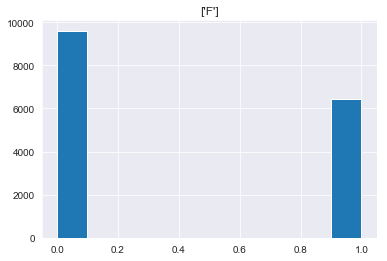

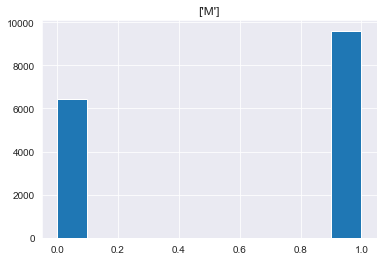

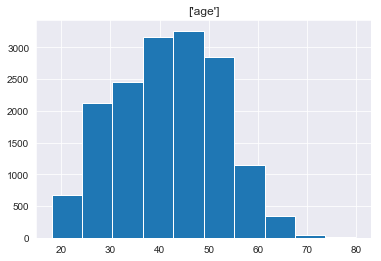

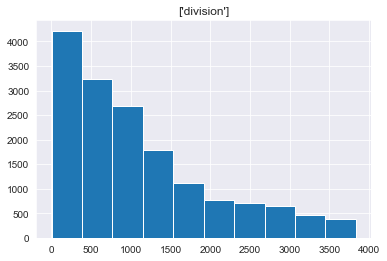

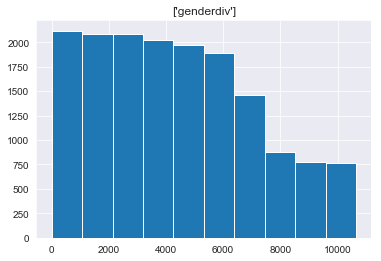

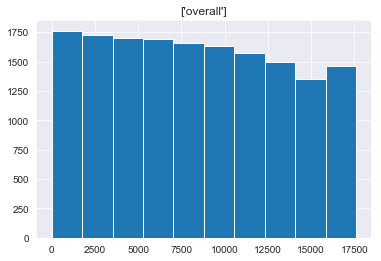

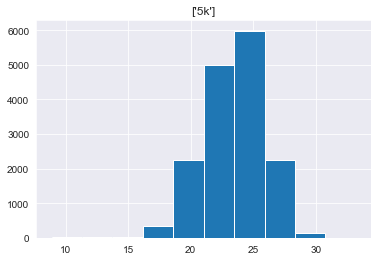

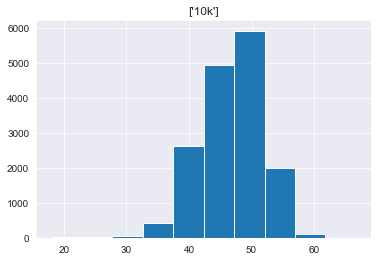

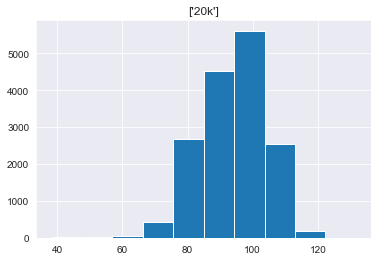

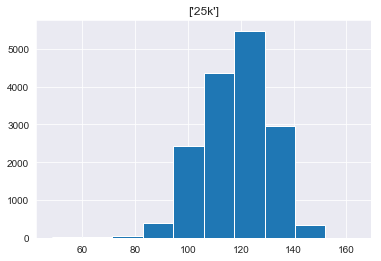

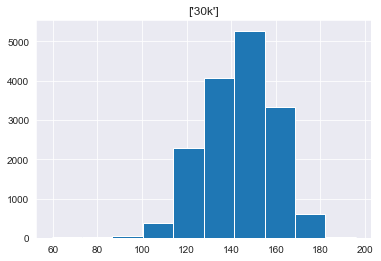

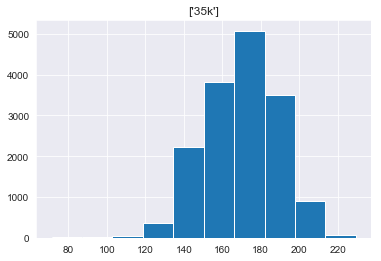

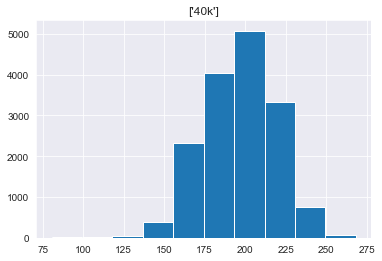

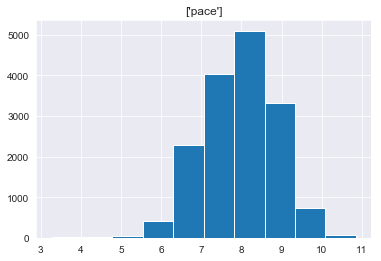

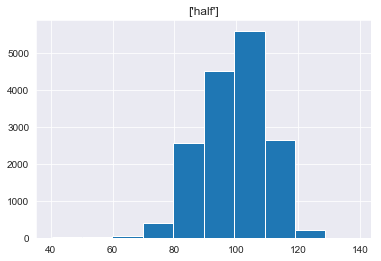

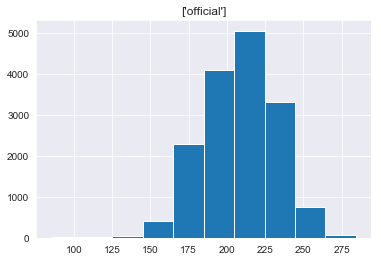

In [16]:
# Check data for Gaussian distributions.
def plotHist(df):
    for col in df.columns:
        plt.hist(df[col], data=df)
        plt.title([col])
        plt.show()
        
plotHist(df)

## Assigning Features and Outcome

In [17]:
# Define the features and the outcome.
X = df.drop(['official'], axis = 1)
Y = df.loc[:, 'official']

## Normalize the data

In [18]:
# Normalize the data.
from sklearn.preprocessing import normalize
X_norm = normalize(X)

#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#df = sc.fit_transform(df)

## Train/Test split & PCA

In [20]:
# Create the 2 feature PCA.
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_norm)

# Split the data into 4 equally sized samples. First we break the half.
from sklearn.model_selection import train_test_split
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size = 0.5,
    random_state = 42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size = 0.5,
    random_state = 42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size = 0.5,
    random_state = 42)

## Clustering Models:
1. K-Means
2. Mean Shift
3. Spectral
4. Affinity Propagation

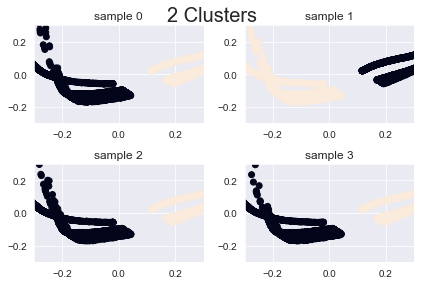

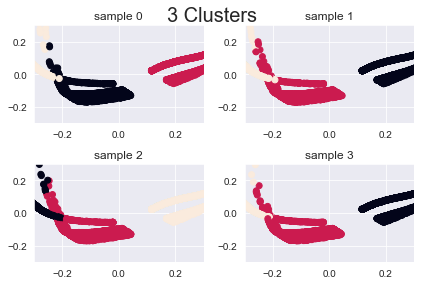

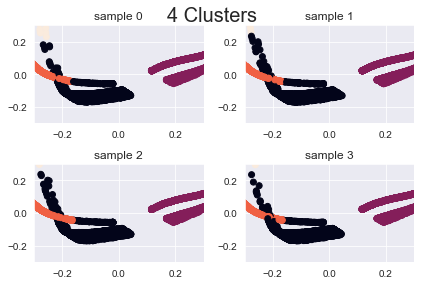

In [21]:
from sklearn.cluster import KMeans

# Create the dataframe to store features and predicted cluster memberships.
ypred = pd.DataFrame()

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [22]:
# Silhouette Coefficient.
def kMeansSilCoeff(num_clust):
    from sklearn import metrics
    from sklearn.metrics import pairwise_distances
    scores = []
    for sample in [X1, X2, X3, X4]:
        model = KMeans(n_clusters=num_clust, random_state=42).fit(sample)
        labels = model.labels_
        scores.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    print('\nK-Means:')
    print('Silhouette Score Mean:', np.mean(scores))
    print('Silhouette Score StdDev:', np.std(scores))
    
def kMeansSilCoeffPCA(num_clust):
    from sklearn import metrics
    from sklearn.metrics import pairwise_distances
    scores_pca = []
    for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
        model = KMeans(n_clusters=num_clust, random_state=42).fit(sample)
        labels = model.labels_
        scores_pca.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    print('Silhouette Score w/ PCA Mean:', np.mean(scores_pca))
    print('Silhouette Score w/ PCA StdDev:', np.std(scores_pca))
    
def meanShiftSilCoeff(num_clust):
    from sklearn.cluster import MeanShift, estimate_bandwidth
    scores = []
    for sample in [X1, X2, X3, X4]:
        bandwidth = estimate_bandwidth(sample, quantile=0.2, n_samples=500)
        model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
        labels = model.labels_
        scores.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    print('\nMean Shift:')
    print('Silhouette Score Mean:', np.mean(scores))
    print('Silhouette Score StdDev:', np.std(scores))
    
def meanShiftSilCoeffPCA(num_clust):
    from sklearn.cluster import MeanShift, estimate_bandwidth
    scores_pca = []
    for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
        bandwidth = estimate_bandwidth(sample, quantile=0.2, n_samples=500)
        model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
        labels = model.labels_
        scores_pca.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    print('Silhouette Score w/ PCA Mean:', np.mean(scores_pca))
    print('Silhouette Score w/ PCA StdDev:', np.std(scores_pca))
    
def spectralClusterSilCoeff(num_clust):
    from sklearn.cluster import SpectralClustering
    scores = []
    for sample in [X1, X2, X3, X4]:
        model = SpectralClustering(n_clusters=num_clust).fit(sample)
        labels = model.labels_
        scores.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    print('\nSpectral Clustering:')
    print('Silhouette Score Mean:', np.mean(scores))
    print('Silhouette Score StdDev:', np.std(scores))
    
def spectralClusterSilCoeffPCA(num_clust):
    from sklearn.cluster import SpectralClustering
    scores_pca = []
    for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
        model = SpectralClustering(n_clusters=num_clust).fit(sample)
        labels = model.labels_
        scores_pca.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    print('Silhouette Score w/ PCA Mean:', np.mean(scores_pca))
    print('Silhouette Score w/ PCA StdDev:', np.std(scores_pca))
    
def affinitySilCoeff(num_clust):
    from sklearn.cluster import AffinityPropagation
    from sklearn import metrics
    scores = []
    for sample in [X1, X2, X3, X4]:
        model = AffinityPropagation().fit(sample)
        labels = model.labels_
        scores.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    print('\nAffinity Propagation:')
    print('Silhouette Score Mean:', np.mean(scores))
    print('Silhouette Score StdDev:', np.std(scores))
    
def affinitySilCoeffPCA(num_clust):
    from sklearn.cluster import AffinityPropagation
    from sklearn import metrics
    scores_pca = []
    for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
        model = AffinityPropagation().fit(sample)
        labels = model.labels_
        scores_pca.append(metrics.silhouette_score(sample, labels, metric='euclidean'))
    print('Silhouette Score w/ PCA Mean:', np.mean(scores_pca))
    print('Silhouette Score w/ PCA StdDev:', np.std(scores_pca))

In [23]:
def runAllModels():
    cluster_list = [2, 3, 4, 5]
    for i in cluster_list:
        print("\nUsing", i, "clusters:")
        kMeansSilCoeff(i)
        kMeansSilCoeffPCA(i)
        meanShiftSilCoeff(i)
        meanShiftSilCoeffPCA(i)
        spectralClusterSilCoeff(i)
        spectralClusterSilCoeffPCA(i)
        affinitySilCoeff(i)
        affinitySilCoeffPCA(i)

# View.
runAllModels()


Using 2 clusters:

K-Means:
Silhouette Score Mean: 0.5211435060490146
Silhouette Score StdDev: 0.003467251440068316
Silhouette Score w/ PCA Mean: 0.5916252852729618
Silhouette Score w/ PCA StdDev: 0.003446040618845965

Mean Shift:
Silhouette Score Mean: 0.6355916224251015
Silhouette Score StdDev: 0.00181193137794475
Silhouette Score w/ PCA Mean: 0.6442582216640848
Silhouette Score w/ PCA StdDev: 0.00485660037576505

Spectral Clustering:
Silhouette Score Mean: 0.5211435060490146
Silhouette Score StdDev: 0.003467251440068316
Silhouette Score w/ PCA Mean: 0.5916252852729618
Silhouette Score w/ PCA StdDev: 0.003446040618845965

Affinity Propagation:
Silhouette Score Mean: 0.12713085686050318
Silhouette Score StdDev: 0.03892688296441352
Silhouette Score w/ PCA Mean: 0.16428351767037963
Silhouette Score w/ PCA StdDev: 0.06239899351689171

Using 3 clusters:

K-Means:
Silhouette Score Mean: 0.6052992878932837
Silhouette Score StdDev: 0.0035744141700661584
Silhouette Score w/ PCA Mean: 0.63668